In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
path = '/content/gdrive/Team Drives/cs273p project'
sys.path.append(path)

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import re
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('wordnet') 

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, MaxPooling1D
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping

from keras import initializers, regularizers, constraints, optimizers, layers

from sklearn.metrics import roc_auc_score

In [0]:
import pickle

def saveobj(save_list, filename):
    with open(path + '/' + filename, 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump(save_list, f)
        
# restore object        
def loadobj(filename):
    with open(path + '/' + filename, 'rb') as f:  # Python 3: open(..., 'rb')
        li = pickle.load(f)
    return li

In [0]:
import data_loader

In [0]:
train_file_path = path + '/data/train.csv'
test_file_path = path + '/data/test.csv'
test_label_file_path = path + '/data/test_labels.csv'

train_df, valid_df = data_loader.load_train_data(train_file_path, valid_rate=0.1, is_df=True)
test_df = data_loader.load_test_data(test_file_path, test_label_file_path, is_df=True)

In [0]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [0]:
print("train_df.shape: ", train_df.shape)
print("valid_df.shape: ", valid_df.shape)
print("test_df.shape: ", test_df.shape) 

train_df.shape:  (143645, 8)
valid_df.shape:  (15926, 8)
test_df.shape:  (63978, 8)


In [0]:
valid_df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
56041,95bf7672a11f2799,Risk factors\n\nThe role of chlamydia should b...,0,0,0,0,0,0
147196,3888c875d6a6a680,"""\nHe isnt listed under """"Other"""" though, last...",0,0,0,0,0,0
52015,8b39ad2e8b8ab63f,So can we use special needs instead of saying ...,0,0,0,0,0,0
85372,e45b67ab32b58e9d,"Right, basically, if something is confusing or...",0,0,0,0,0,0
78183,d14461a0cb85bf6f,being made by removing well-sourced material f...,0,0,0,0,0,0


## Preprocessed Visualization
1. any missing values "null"

2. Statistics of each class 
   - percentage
      - not labeled
      - each class
      
3. correlation between classes
   - heatmap 
       - filter out all zero comment
       - compare among classes

No any missing values from the trainning data

In [0]:
train_df.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

Probability of each class being 1

In [0]:
train_df[classes].mean() 

toxic            0.096084
severe_toxic     0.010018
obscene          0.053277
threat           0.003021
insult           0.049664
identity_hate    0.008786
dtype: float64

In [0]:
nonToxicProb = (train_df[classes] == 0).all(axis = 1).mean() * 100
print("Probability of non toxic comment is {}%".format(nonToxicProb))

Probability of non toxic comment is 89.80890389501897%


Text(0.5, 1.0, 'Classes correlation')

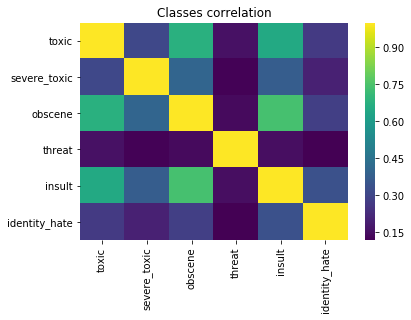

In [0]:
cls_corr = train_df[classes].corr()
color = plt.cm.viridis
sns.heatmap(cls_corr, cmap = color)
plt.title("Classes correlation")

The heatmap above shows stronger correlation among:
(toxic, obscene,  insult)

## Preprocessing

### Text Cleaning
1. Lowercasing
2. Remove punctuation
3. Remove marginal white space or newline
      - strip left and right
      - \n
4. Remove stop words
5. Lemmatization

### After clean up, remove empty string

In [0]:
lemtzr = WordNetLemmatizer() 

def dataCleaning(row):
  txt = row['comment_text']
  txt = txt.lower() 
  
  ## expand contraction 
  ## code from https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
  txt = re.sub(r"won\'t", "will not", txt)
  txt = re.sub(r"can\'t", "can not", txt)
  txt = re.sub(r"n\'t", " not", txt)
  txt = re.sub(r"\'re", " are", txt)
  txt = re.sub(r"\'s", " is", txt)
  txt = re.sub(r"\'d", " would", txt)
  txt = re.sub(r"\'ll", " will", txt)
  txt = re.sub(r"\'t", " not", txt)
  txt = re.sub(r"\'ve", " have", txt)
  txt = re.sub(r"\'m", " am", txt)
  
  txt = re.sub('\W', ' ', txt)                                                  # remove non word characters
  txt = re.sub('\s+', ' ', txt)                                                 # remove white spaces
  
  txt = ' '.join([lemtzr.lemmatize(wrd) for wrd in txt.split(' ')])             # lemmatize
  return txt.strip()



In [0]:
train_df['filt_comment'] = train_df.apply(dataCleaning, axis = 1)
valid_df['filt_comment'] = valid_df.apply(dataCleaning, axis = 1)
test_df['filt_comment'] = test_df.apply(dataCleaning, axis = 1)

In [0]:
saveobj([train_df, valid_df, test_df], 'data/clean_pickle')

In [0]:
# load pickle
train_df, valid_df, test_df = loadobj('data/clean_pickle')

## Vectorized and Transform 

### NN Tokenizing/Indexing/Index Representation

In [0]:
y = train_df[classes].values
Y_v = valid_df[classes].values
Y_t = test_df[classes].values
list_sentences_train = train_df["filt_comment"]
list_sentences_valid = valid_df["filt_comment"]
list_sentences_test = test_df["filt_comment"]

In [0]:
# Original comment text without filter

# y = train_df[classes].values
# list_sentences_train = train_df["comment_text"]
# list_sentences_test = test_df["comment_text"]

## RNN

### RNN tokenization

In [0]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_valid = tokenizer.texts_to_sequences(list_sentences_valid)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [0]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_v = pad_sequences(list_tokenized_valid, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

Distribution of the number of words in sentences, pad the tokens to maxlen=200

In [0]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

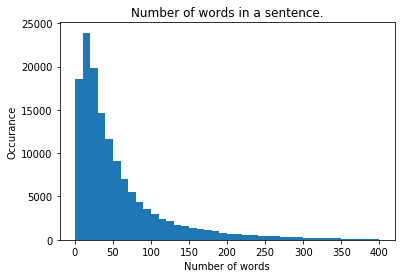

In [0]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.title('Number of words in a sentence.')
plt.xlabel('Number of words')
plt.ylabel('Occurance')
plt.show()

### RNN Model (GRU)

- Input Layer:
- Embedding Layer:
 - project the words to a vector space depending on the distance of the surrounding words in a sentence.
 - reduce model size and huge dimensions
 - The output of the layer is just a list of the coordinates of the words in this vector space. 
- LSTM Layer
- Max Pooling Layer
 - reshape the 3D tensor into a 2D one.

In [0]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = GRU(60, return_sequences=True,name='GRU_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
GRU_layer (GRU)              (None, 200, 60)           34020     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 60)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 366       
Total params: 2,594,386
Trainable params: 2,594,386
Non-trainable params: 0
_________________________________________________________________


In [0]:
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks = [callback_early_stopping]

In [0]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_data=(X_v, Y_v), callbacks=callbacks)

Train on 143645 samples, validate on 15926 samples
Epoch 1/2
143645/143645 [==============================] - 1083s 8ms/step - loss: 0.0618 - acc: 0.9793 - val_loss: 0.0465 - val_acc: 0.9825
Epoch 2/2
143645/143645 [==============================] - 1070s 7ms/step - loss: 0.0418 - acc: 0.9841 - val_loss: 0.0440 - val_acc: 0.9835


In [0]:
model.save(path + '/output/neural network/gru_model.h5')  #

In [0]:
# returns a compiled model
gru_model = load_model(path + '/output/neural network/gru_model.h5')

In [0]:
rnn_Y_t_p = gru_model.predict(X_te, batch_size=batch_size, verbose=1)

63978/63978 [==============================] - 181s 3ms/step


In [0]:
rnn_Y_t_p[24]

array([0.9941517 , 0.24305743, 0.9507938 , 0.04716605, 0.82694703,
       0.6341098 ], dtype=float32)

In [0]:
rnn_Y_t[24]

array([1, 0, 1, 0, 1, 1])

In [0]:
scores = []
submission = pd.DataFrame.from_dict({'id': test_df['id']})
for i,class_name in enumerate(classes):
    cv_score = roc_auc_score(Y_t[:,i], rnn_Y_t_p[:,i])
    scores.append(cv_score)
    print (class_name, ': ', cv_score)
    submission[class_name] = rnn_Y_t_p[:,i]
    
print('Total CV score is {}'.format(np.mean(scores)))
submission.to_csv(path + r'/output/neural network/RNN_submission.csv', index=False)

toxic :  0.9673779461795202
severe_toxic :  0.9882611814992497
obscene :  0.9769079036855035
threat :  0.9832581026436812
insult :  0.9743989175911283
identity_hate :  0.9841695572324024
Total CV score is 0.9790622681385809


## CNN

### CNN Tokenization

Split at character level, instead of word level like RNN

In [0]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features,char_level=True)

In [0]:
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_valid = tokenizer.texts_to_sequences(list_sentences_valid)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [0]:
maxlen = 500
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_v = pad_sequences(list_tokenized_valid, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

Reason why we pick 500:

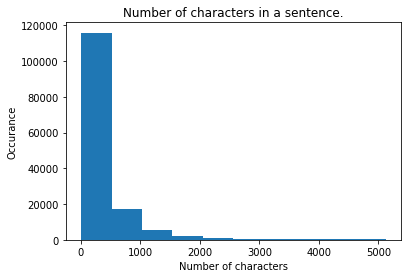

In [0]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords)
plt.title('Number of characters in a sentence.')
plt.xlabel('Number of characters')
plt.ylabel('Occurance')
plt.show()

### CNN Model

In [0]:
inp = Input(shape=(maxlen, ))
embed_size = 240
x = Embedding(len(tokenizer.word_index)+1, embed_size)(inp)
x = Conv1D(filters=100,kernel_size=4,padding='same', activation='relu')(x)
x=MaxPooling1D(pool_size=4)(x)
x = Bidirectional(GRU(60, return_sequences=True,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                 metrics=['accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 500, 240)          365280    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 100)          96100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 125, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 125, 120)          57960     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6050      
__________

In [0]:
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks = [callback_early_stopping]

In [0]:
batch_size = 32
epochs = 6
hist = model.fit(X_t, y, batch_size=batch_size, epochs=epochs,
                 validation_data=(X_v, Y_v),callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 143645 samples, validate on 15926 samples
Epoch 1/6
143645/143645 [==============================] - 1631s 11ms/step - loss: 0.0794 - acc: 0.9761 - val_loss: 0.0610 - val_acc: 0.9799
Epoch 2/6
143645/143645 [==============================] - 1586s 11ms/step - loss: 0.0584 - acc: 0.9805 - val_loss: 0.0556 - val_acc: 0.9812
Epoch 3/6
143645/143645 [==============================] - 1568s 11ms/step - loss: 0.0539 - acc: 0.9813 - val_loss: 0.0528 - val_acc: 0.9819
Epoch 4/6
143645/143645 [==============================] - 1607s 11ms/step - loss: 0.0513 - acc: 0.9818 - val_loss: 0.0509 - val_acc: 0.9822
Epoch 5/6
143645/143645 [==============================] - 1594s 11ms/step - loss: 0.0497 - acc: 0.9822 - val_loss: 0.0501 - val_acc: 0.9822
Epoch 6/6
143645/143645 [==============================] - 1537s 11ms/step - loss: 0.0485 - acc: 0.9826 - val_loss: 0.

In [0]:
model.save(path + '/output/neural network/cnn_model.h5')  #

# returns a compiled model
cnn_model = load_model(path + '/output/neural network/cnn_model.h5')

In [0]:
cnn_Y_t_p = cnn_model.predict(X_te, batch_size=batch_size, verbose=1)

63978/63978 [==============================] - 263s 4ms/step


In [0]:
scores = []
submission = pd.DataFrame.from_dict({'id': test_df['id']})
for i,class_name in enumerate(classes):
    cv_score = roc_auc_score(Y_t[:,i], cnn_Y_t_p[:,i])
    scores.append(cv_score)
    print (class_name, ': ', cv_score)
    submission[class_name] = cnn_Y_t_p[:,i]
    
print('Total CV score is {}'.format(np.mean(scores)))
submission.to_csv(path + r'/output/neural network/CNN_submission.csv', index=False)

toxic :  0.9594618800156307
severe_toxic :  0.9859726418712305
obscene :  0.9752332625576052
threat :  0.9788533298471025
insult :  0.9695588094541403
identity_hate :  0.9700995165054841
Total CV score is 0.9731965733751989
